In [1]:
## This notebook describes how to use some basic functionalities of s4cmb such as
## * simulate an input sky
## * simulate an instrument 
## * simulate a scanning strategy
## * simulate TOD from the 3 previous guys
## * project back your TOD to sky maps.

In [2]:
import sys
import os

## Include your path to the package
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../../s4cmb')))

## Import modules and routines
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import TimeOrderedDataDemod
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full

## Other packages needed
import healpy as hp
import pylab as pl
import numpy as np

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

In [3]:
#################################################################
## START OF THE SIMULATION
## Flow is the following: 
##   sky -> instrument -> scanning strategy -> 
##   MAP2TOD -> (systematics) -> TOD2MAP
##################################################################

In [4]:
## Initialise our input maps 
## (for test purposes, we create the maps on-the-fly from a CAMB file)
## Note that HealpixFitsMap can take as input a fits file with sky maps already in.
sky_in = HealpixFitsMap('../../s4cmb/s4cmb/data/test_data_set_lensedCls.dat', do_pol=True, 
                        fwhm_in=3.5, nside_in=512, map_seed=5843787, verbose=False, 
                        no_ileak=False, no_quleak=False)

In [5]:
## Initialise our instrument
## Generate a focal plane with 4 Crate boards, each with 1 MUX board, 
## each with 1 Squid, each with 16 pairs of bolometers.
## The focal plane is 60 cm wide (square),
## and each detector beam is Gaussian with FWHM of 3.5 arcmin.
## We choose a pointing model with 5 parameters.
## Finally, we mount a continously rotating HWP @ 2Hz on the instrument.
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=1., angle_hwp=0., verbose=False)

In [6]:
## Initialize our scanning strategy
## Our scanning strategy will consist in scanning the Southern sky from Chile.
## We will perform 1 deep scan (CES) of roughly 4h.
## We will start the observation January, 1st 2013.
## We will set the sampling frequency of the detector to be 8 Hz, and we will 
## scan the sky at a speed of 0.4 deg/s.
scan = ScanningStrategy(nces=1, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=24., sky_speed=0.4,
                        ut1utc_fn='../../s4cmb/s4cmb/data/ut1utc.ephem', language='fortran')
# scan.begin_LST = ['17:07:54.84']
# scan.end_LST = ['17:22:21.76']
scan.run()

In [7]:
## Let's now generate our TOD from our input sky, instrument, and scanning strategy
## Firts, we will use the difference of pairs of detectors to reconstruct 
## the polarisation (no demodulation).
## Once we will have the timestreams, we will reconstruct our maps on a 
## sky patch of width 20 deg at a resolution nside = 512.

## MAP2TOD: scan the input sky to generate timestream channel-by-channel.
## this is currently the bottleneck in computation. Need to speed-up this routine!
## Hopefully everything is linear ;-)

## This is where you want to parallelize for big runs, so that different processors 
## (or groups or procs) focus on different scans. Here is the serial version:
nside_out = 512

## Loop over scans
for CESnumber in range(scan.nces):
    tod_demod = TimeOrderedDataDemod(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', nside_out=nside_out, width=130., 
        mapping_perpair=True)
    tod_diff = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', nside_out=nside_out, width=130., 
        mapping_perpair=True)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky_demod = OutputSkyMap(
            projection=tod_demod.projection, 
            nside=tod_demod.nside_out, 
            obspix=tod_demod.obspix,
            demodulation=True)
        sky_diff = OutputSkyMap(
            projection=tod_diff.projection, 
            nside=tod_diff.nside_out, 
            obspix=tod_diff.obspix,
            demodulation=False)
        
    for pair in tqdm(tod_demod.pair_list):
        d_demod = np.array([tod_demod.map2tod(det) for det in pair])
        d_demod = tod_demod.demodulate_timestreams(d_demod)
        tod_demod.tod2map(d_demod, sky_demod)
        
        d_diff = np.array([tod_diff.map2tod(det) for det in pair])
        tod_diff.tod2map(d_diff, sky_diff)

100%|██████████| 64/64 [01:14<00:00,  1.11s/it]


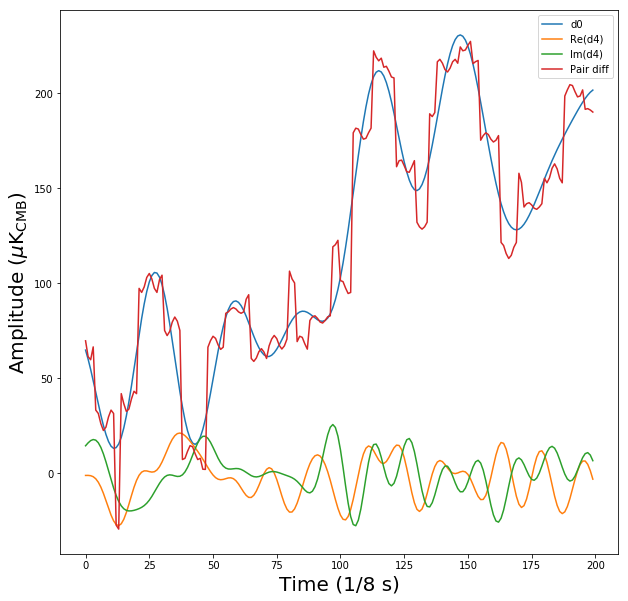

In [8]:
## Let's have a look at some TOD, that is 
## d(t) = I(t) + Q(t)cos(2*theta(t)) + U(t)sin(2*theta(t)).
## Keep in mind we set the sample rate at 8 Hz.
bolo=0
fig = pl.figure(figsize=(10, 10))
pl.plot(d_demod[bolo][0][0:200], label='d0')
pl.plot(d_demod[bolo][1][0:200], label='Re(d4)')
pl.plot(d_demod[bolo][2][0:200], label='Im(d4)')
pl.plot(d_diff[bolo][0:200], label='Pair diff')
pl.legend()
pl.xlabel('Time (1/8 s)', fontsize=20)
pl.ylabel('Amplitude ($\mu$K$_{\\rm CMB}$)', fontsize=20)
pl.show()

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Library/Python/2.7/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


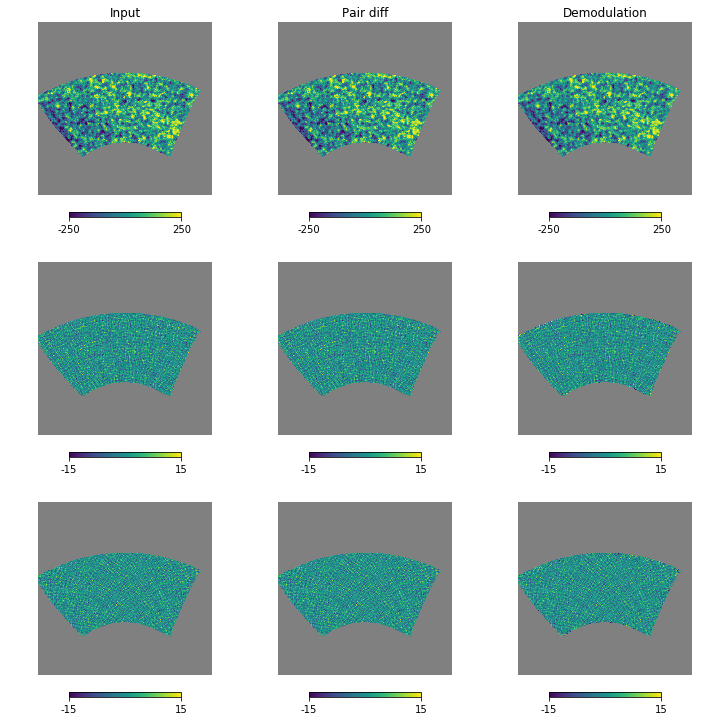

In [9]:
## In the absence of systematics, these operations should not change the 
## signal. Let's check that we did not harm the signal.
xsize = 500
fig = pl.figure(figsize=(10, 10))

nhit_diff = partial2full(
    sky_diff.nhit, 
    sky_diff.obspix, 
    sky_diff.nside, fill_with=0.0)

nhit_demod = partial2full(
    sky_demod.nhit, 
    sky_demod.obspix, 
    sky_demod.nside, fill_with=0.0)

## Temperature
sky_diff_I = partial2full(
    sky_diff.get_I(), 
    sky_diff.obspix, 
    sky_diff.nside, fill_with=0.0)
sky_demod_I = partial2full(
    sky_demod.get_I(), 
    sky_demod.obspix, 
    sky_demod.nside, fill_with=0.0)

mask_diff = nhit_diff < 1
mask_demod = nhit_demod < 1
# sky_in.I[mask] = np.nan
sky_input = sky_in.I + 0.0
sky_input[mask_diff] = np.nan
sky_diff_I[mask_diff] = np.nan
sky_demod_I[mask_demod] = np.nan
hp.gnomview(sky_input, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=331, 
            title='Input', notext=True, min=-250, max=250)
hp.gnomview(sky_diff_I, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=332, 
            title='Pair diff', notext=True, min=-250, max=250)
hp.gnomview(sky_demod_I, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=333, 
            title='Demodulation', notext=True, min=-250, max=250)

## Stokes Q
sky_diff_Q = partial2full(
    sky_diff.get_QU()[0], 
    sky_diff.obspix, 
    sky_diff.nside, fill_with=0.0)
sky_demod_Q = partial2full(
    sky_demod.get_QU()[0], 
    sky_demod.obspix, 
    sky_demod.nside, fill_with=0.0)

mask_diff = nhit_diff < 10
mask_demod = nhit_demod < 10
sky_input = sky_in.Q + 0.0
sky_input[mask_diff] = np.nan
sky_diff_Q[mask_diff] = np.nan
sky_demod_Q[mask_demod] = np.nan

hp.gnomview(sky_input, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=334, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_diff_Q, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=335,  
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_demod_Q, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=336, 
            notext=True, title='', min=-15, max=15)

## Stokes Q
sky_diff_U = partial2full(
    sky_diff.get_QU()[1], 
    sky_diff.obspix, 
    sky_diff.nside, fill_with=0.0)
sky_demod_U = partial2full(
    sky_demod.get_QU()[1], 
    sky_demod.obspix, 
    sky_demod.nside, fill_with=0.0)

mask_diff = nhit_diff < 10
mask_demod = nhit_demod < 10
sky_input = sky_in.U + 0.0
sky_input[mask_diff] = np.nan
sky_diff_U[mask_diff] = np.nan
sky_demod_U[mask_demod] = np.nan

hp.gnomview(sky_input, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=337, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_diff_U, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=338,  
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_demod_U, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=339, 
            notext=True, title='', min=-15, max=15)

pl.show()